# Package Usage Example

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample

import torch
from torch.utils.data import Dataset,DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

from Multi_Layer_Kernel_Machine.Mydataset import mydataset
from Multi_Layer_Kernel_Machine.RandomFeature import RandomFourierFeature
from Multi_Layer_Kernel_Machine.Fitting import MultilayerFitting
from Multi_Layer_Kernel_Machine.Structure import Net,ResNet,KernelNet,ResKernelNet
from Multi_Layer_Kernel_Machine.DataSplitting import DataSplitting
from Multi_Layer_Kernel_Machine.GenerateSplit import GenerateSplit

In [2]:
##### example
df=pd.read_csv('YearPredictionMSD.txt',header=None,sep = ',')
#smaller dataset
train=df.iloc[300000:300700]
calibration=df.iloc[400000:400500]
test=df.iloc[500000:500300] 

train_y = train[0]
calibration_y = calibration[0]
test_y = test[0] #response:year
train_x = train
calibration_x = calibration
test_x = test
del train_x[0]
del calibration_x[0]
del test_x[0]
total_x=pd.concat([train_x,test_x])
total_x=pd.concat([total_x,calibration_x])
x=preprocessing.StandardScaler().fit(total_x).transform(total_x) #normalize
x=pd.DataFrame(x)
train_x=x.iloc[:700]
test_x=x.iloc[700:1000]
calibration_x=x.iloc[1000:]

train_x.reset_index(drop=True, inplace=True) 
calibration_x.reset_index(drop=True, inplace=True) 
test_x.reset_index(drop=True, inplace=True) 
train_y.reset_index(drop=True, inplace=True) 
calibration_y.reset_index(drop=True, inplace=True) 
test_y.reset_index(drop=True, inplace=True) 


train_x.shape,calibration_x.shape,test_x.shape

((700, 90), (500, 90), (300, 90))

In [3]:
##### data
nntrain_x = torch.from_numpy(train_x.to_numpy()).float()
nntrain_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float()) 
nntest_x= torch.from_numpy(test_x.to_numpy()).float()
nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())
    
    
batch=100
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=batch, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=batch, shuffle=False)

## Multilayer Structure

In [4]:
##### DNN example
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=0.1)
        m.bias.data.fill_(0.01)  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net([90,32,8,1],device) 
print(net)
torch.manual_seed(0)
net.apply(init_weights)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-6,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
mlmodel=MultilayerFitting(net,device,train_loader, test_loader, 2000, criterion, optimizer,100,100)
dnn_trainloss,dnn_testloss,dnn_bootbase=mlmodel.fitting(train_x,train_y,test_x,test_y)
#mlmodel.Bootstrap(40,dnn_bootbase,train_x,train_y,test_x,test_y, batch,init_weights)

Net(
  (layers): ModuleList(
    (0): Linear(in_features=90, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)
epoch 0
                    Train set - loss: 3983575.146122837
                    Test  set - loss: 3985007.471276696
                    
epoch 100
                    Train set - loss: 331.7391438661941
                    Test  set - loss: 2756.611956657966
                    
epoch 200
                    Train set - loss: 112.03384731299111
                    Test  set - loss: 1347.2085443268716
                    
epoch 300
                    Train set - loss: 71.42526242643595
                    Test  set - loss: 1089.0420378831525
                    
epoch 400
                    Train set - loss: 55.87453827285341
                    Test  set - loss: 1006.3333005803327
                    
epoch 500
                    Train set

In [5]:
##### ResNet example
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=0.1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = ResNet([90,32,8,1],device)
print(net)
torch.manual_seed(0)
net.apply(init_weights)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=5e-7,momentum=0.9,weight_decay=1e-2)
mlmodel=MultilayerFitting(net,device,train_loader, test_loader, 2000, criterion, optimizer,100,100)
res_trainloss,res_testloss,res_bootbase=mlmodel.fitting(train_x,train_y,test_x,test_y)
#mlmodel.Bootstrap(40,res_bootbase,train_x,train_y,test_x,test_y, batch,init_weights)

ResNet(
  (layers): ModuleList(
    (0): ResidualBlock1(
      (fc1): Linear(in_features=90, out_features=32, bias=True)
      (fc2): Linear(in_features=90, out_features=32, bias=True)
    )
    (1): ResidualBlock1(
      (fc1): Linear(in_features=32, out_features=8, bias=True)
      (fc2): Linear(in_features=32, out_features=8, bias=True)
    )
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)
epoch 0
                    Train set - loss: 3976256.1381272324
                    Test  set - loss: 3979541.61794532
                    
epoch 100
                    Train set - loss: 516.7128231975223
                    Test  set - loss: 5447.853179610818
                    
epoch 200
                    Train set - loss: 142.23778106440392
                    Test  set - loss: 2565.106378117204
                    
epoch 300
                    Train set - loss: 86.11773866449083
                    Test  set - loss: 1985.7226245799163
                    
epoch 400
      

In [6]:
##### MLK example
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = KernelNet([90,32,8,1],["C","G"],[0.01,0.1],device)
print(net)
torch.manual_seed(1)
net.apply(init_weights)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-3,momentum=0.9,weight_decay=1e-4) #optim.Adam(...)
mlmodel=MultilayerFitting(net,device,train_loader, test_loader, 2000, criterion, optimizer,100,100)
kernelnn_trainloss,kernelnn_testloss,kernelnn_bootbase=mlmodel.fitting(train_x,train_y,test_x,test_y)
#mlmodel.Bootstrap(40,kernelnn_bootbase,train_x,train_y,test_x,test_y, batch,init_weights)

KernelNet(
  (layers): ModuleList(
    (0): Linear(in_features=32, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=1, bias=True)
  )
)
epoch 0
                    Train set - loss: 3691516.111852238
                    Test  set - loss: 3696170.7101634447
                    
epoch 100
                    Train set - loss: 628.0146386465643
                    Test  set - loss: 1724.8219885035853
                    
epoch 200
                    Train set - loss: 238.78524634599685
                    Test  set - loss: 632.8809890638788
                    
epoch 300
                    Train set - loss: 150.44935376463192
                    Test  set - loss: 340.95648453826703
                    
epoch 400
                    Train set - loss: 128.1610644170216
                    Test  set - loss: 251.94654342229168
                    
epoch 500
                    Train set - loss: 122.04451103063566
                    Test  set - loss: 223.08576322481036

In [7]:
### RK example
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = ResKernelNet([90,32,8,1],["C","G"],[0.01,0.1],device)
print(net)
torch.manual_seed(1)
net.apply(init_weights)
criterion=nn.MSELoss() 
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-6,momentum=0.9,weight_decay=1e-4) #optim.Adam(...)
mlmodel=MultilayerFitting(net,device,train_loader, test_loader, 2000, criterion, optimizer,100,100)
reskernel_trainloss,reskernel_testloss,reskernel_bootbase=mlmodel.fitting(train_x,train_y,test_x,test_y)
#mlmodel.Bootstrap(40,reskernel_bootbase,train_x,train_y,test_x,test_y, batch,init_weights)

ResKernelNet(
  (layers): ModuleList(
    (0): ResidualBlock2(
      (fc1): Linear(in_features=32, out_features=8, bias=True)
      (fc2): Linear(in_features=8, out_features=8, bias=True)
    )
    (1): Linear(in_features=8, out_features=1, bias=True)
  )
)
epoch 0
                    Train set - loss: 3985232.8349189814
                    Test  set - loss: 3986902.9108311003
                    
epoch 100
                    Train set - loss: 352.7170183297992
                    Test  set - loss: 353.13146307860814
                    
epoch 200
                    Train set - loss: 204.91885562932916
                    Test  set - loss: 255.14130746901034
                    
epoch 300
                    Train set - loss: 171.66385909961804
                    Test  set - loss: 232.4470315868159
                    
epoch 400
                    Train set - loss: 155.35865145438484
                    Test  set - loss: 218.73159810960294
                    
epoch 500
           

In [8]:
### single layer example
model =Ridge(alpha=1)
score=[]
trainmse=[]
testmse=[]
gaset=np.linspace(0,0.3,10)
for ga in gaset:
    rff=RandomFourierFeature(90,100,kernel='G',gamma=ga,device="cpu")
    train_xtransformed=rff.transform(nntrain_x)
    test_xtransformed=rff.transform(nntest_x)
    model.fit(train_xtransformed, nntrain_y)
    y_pretest=model.predict(test_xtransformed)
    y_pretrain=model.predict(train_xtransformed)
    score.append(cross_val_score(model,train_xtransformed,train_y,cv=5).mean())   ##cross-validation
    trainmse.append(mean_squared_error(y_pretrain,train_y))
    testmse.append(mean_squared_error(y_pretest,test_y))
ind=score.index(max(score))
print("cv-score,index,gamma,trainmse,testmse",max(score),ind,gaset[ind],trainmse[ind],testmse[ind])

cv-score,index,gamma,trainmse,testmse -0.8196721763498438 2 0.06666666666666667 95.19869029903126 159.09465285817078


estimation

In [9]:
##### MLK interval example
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = KernelNet([90,32,8,1],["C","G"],[0.01,0.1],device)
print(net)
torch.manual_seed(1)
net.apply(init_weights)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-3,momentum=0.9,weight_decay=1e-4) #optim.Adam(...)
mlmodel=MultilayerFitting(net,device,train_loader, test_loader, 2000, criterion, optimizer,100,100,printchoice=False)
kernelnn_trainloss,kernelnn_testloss,kernelnn_bootbase=mlmodel.fitting(train_x,train_y,test_x,test_y)

mlmodel.HomoConformalBand(train_x,train_y,test_x,test_y, calibration_x,calibration_y)
mlmodel.HeteConformalBand(kernelnn_trainloss,train_x,train_y,test_x,test_y, calibration_x,calibration_y)

KernelNet(
  (layers): ModuleList(
    (0): Linear(in_features=32, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=1, bias=True)
  )
)
476.0
length tensor(47.6919)
95 coverage 0.9966666666666667


100%|██████████| 500/500 [00:00<00:00, 1380.82it/s]


476.0


100%|██████████| 300/300 [00:00<00:00, 1425.97it/s]

length 50.738255399068194
95 coverage 0.91


(50.738255399068194, 0.91)

comparison

In [10]:
def plot_choose(fig,start,data):
    fig.plot(np.arange(start,len(data)),data[start:])

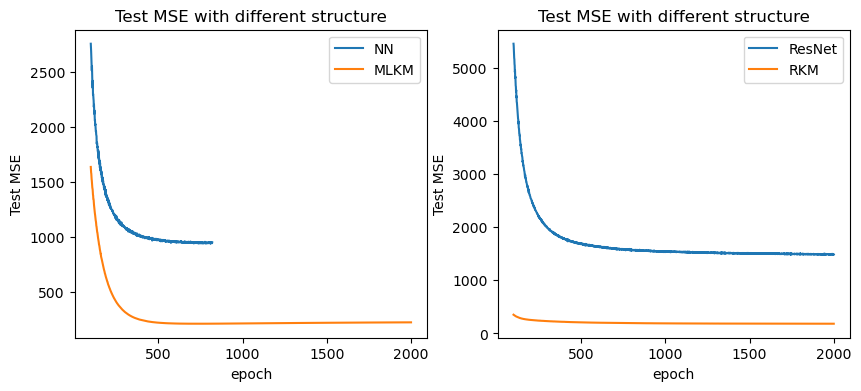

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_choose(ax[0],100,dnn_testloss)
plot_choose(ax[0],100,kernelnn_testloss)
ax[0].legend(["NN","MLKM"])
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("Test MSE")
ax[0].set_title("Test MSE with different structure")

plot_choose(ax[1],100,res_testloss)
plot_choose(ax[1],100,reskernel_testloss)
ax[1].legend(["ResNet","RKM"])
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("Test MSE")
ax[1].set_title("Test MSE with different structure")

plt.show()

## data splitting

In [12]:
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = KernelNet([90,32,8,1],["C","G"],[0.01,0.1],device)
train_loaderset,netset,optimizerset=GenerateSplit(2,device,net,8e-4,0.9,1e-4,
                                                                       train_x,train_y, batch,init_weights)
criterion=nn.MSELoss()  
split=2  
splkermodel=DataSplitting(split,netset,device,train_loaderset, test_loader, 2000, criterion, optimizerset,100,100,printchoice=True)
splker_trainloss,splker_testloss,splker_prediction=splkermodel.fitting(train_x,train_y,test_x,test_y)

epoch 0
                    Train set - loss: 3662350.05582375
                    Test  set - loss: 3669310.4304550234
                    
epoch 100
                    Train set - loss: 697.5303526145645
                    Test  set - loss: 1487.5905697820583
                    
epoch 200
                    Train set - loss: 246.40364489472339
                    Test  set - loss: 566.1330834285418
                    
epoch 300
                    Train set - loss: 155.40491936323897
                    Test  set - loss: 333.4761670646568
                    
epoch 400
                    Train set - loss: 130.5676529004744
                    Test  set - loss: 252.43291435033083
                    
epoch 500
                    Train set - loss: 122.73355795713408
                    Test  set - loss: 222.25781553283335
                    
epoch 600
                    Train set - loss: 119.51849349999002
                    Test  set - loss: 209.8699434950451
               

In [14]:
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = ResKernelNet([90,32,8,1],["C","G"],[0.01,0.1],device)
train_loaderset,netset,optimizerset=GenerateSplit(2,device,net,8e-7,0.9,1e-4,
                                                                       train_x,train_y, batch,init_weights)
criterion=nn.MSELoss()    
split=2 
splresmodel=DataSplitting(split,netset,device,train_loaderset, test_loader, 2000, criterion, optimizerset,100,100,printchoice=True)
splres_trainloss,splres_testloss,splres_prediction=splresmodel.fitting(train_x,train_y,test_x,test_y)

epoch 0
                    Train set - loss: 3980618.4521692316
                    Test  set - loss: 3982431.410348789
                    
epoch 100
                    Train set - loss: 269.45194674198115
                    Test  set - loss: 306.4294250240922
                    
epoch 200
                    Train set - loss: 214.09092659880008
                    Test  set - loss: 267.8530656429132
                    
epoch 300
                    Train set - loss: 188.3568997952129
                    Test  set - loss: 253.02303251395622
                    
epoch 400
                    Train set - loss: 172.48751387095876
                    Test  set - loss: 244.5106906442841
                    
epoch 500
                    Train set - loss: 161.63913900143334
                    Test  set - loss: 238.07265293086567
                    
epoch 600
                    Train set - loss: 153.7094065532301
                    Test  set - loss: 234.16218999400735
              

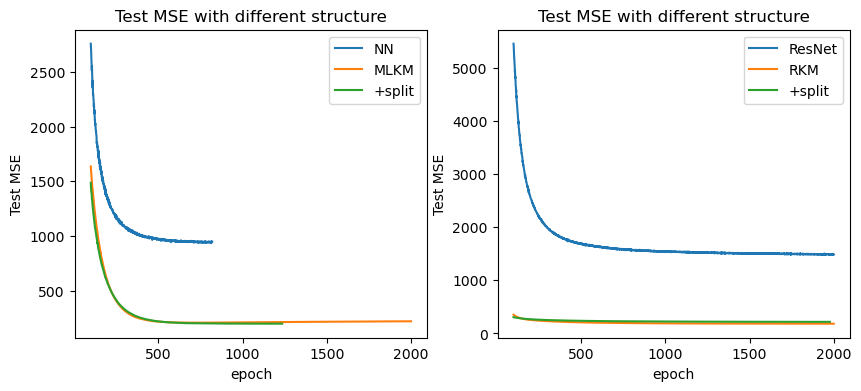

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_choose(ax[0],100,dnn_testloss)
plot_choose(ax[0],100,kernelnn_testloss)
plot_choose(ax[0],100,splker_testloss)
ax[0].legend(["NN","MLKM","+split"])
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("Test MSE")
ax[0].set_title("Test MSE with different structure")

plot_choose(ax[1],100,res_testloss)
plot_choose(ax[1],100,reskernel_testloss)
plot_choose(ax[1],100,splres_testloss)
ax[1].legend(["ResNet","RKM","+split"])
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("Test MSE")
ax[1].set_title("Test MSE with different structure")
plt.show()